This is the code used to analyze two Airbnb Data Sets: Seattle and Boston rentals.

This analyses are using CRISP-DM model for data mining that consists of the following phases:
* Business Understanding
* Data Understanding
* Data Preparation
* Modeling
* Evaluation
* Deployment

In [45]:
import pandas as pd
import numpy as np
import os
import zipfile as z
import seaborn as sns
import matplotlib. pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.model_selection import GridSearchCV, train_test_split


## AirBnB data

### 3 Questions on the data to explore

#### 1) Are there rental differences between the cities?
#### 2) Is there a seasonality in the bookings?
#### 3) What are the main predictors for the price of a rental?

In [46]:
#read the files from the zips
seattle = z.ZipFile('seattle.zip')
seattle_calendar = pd.read_csv(seattle.open('calendar.csv'), parse_dates=['date'])

In [47]:
seattle_listings = pd.read_csv(seattle.open('listings.csv'))
seattle_reviews  = pd.read_csv(seattle.open('reviews.csv'))

In [48]:
boston = z.ZipFile('boston.zip')
boston_calendar = pd.read_csv(boston.open('calendar.csv'), parse_dates=['date'])

In [49]:
boston_listings = pd.read_csv(boston.open('listings.csv'))
boston_reviews  = pd.read_csv(boston.open('reviews.csv'))

In [50]:
#compare columns in both sets
print('seattle calendar cols: ',seattle_calendar.shape[1])
print('seattle listings cols: ',seattle_listings.shape[1])
print('seattle reviews cols: ',seattle_reviews.shape[1])
print('boston calendar cols: ',boston_calendar.shape[1])
print('boston listings cols: ',boston_listings.shape[1]) #check what's the difference
print('boston reviews cols: ',boston_reviews.shape[1])

seattle calendar cols:  4
seattle listings cols:  92
seattle reviews cols:  6
boston calendar cols:  4
boston listings cols:  95
boston reviews cols:  6


### Q1 What are the differences between the two cities?

In [51]:
#drop duplicates in calendar files
boston_calendar = boston_calendar.sort_values(by = ['listing_id', 'date', 'available'])
boston_calendar = boston_calendar.drop_duplicates(['listing_id', 'date', 'available'], keep='first')
seattle_calendar = seattle_calendar.sort_values(by = ['listing_id', 'date', 'available'])
seattle_calendar = seattle_calendar.drop_duplicates(['listing_id', 'date', 'available'], keep='first')

In [52]:
#turn price into int
seattle_calendar.price = seattle_calendar.price.str.replace('$','').str.replace(',','').astype('float')
boston_calendar.price = boston_calendar.price.str.replace('$','').str.replace(',','').astype('float')

In [53]:
#what is the date range?
print(seattle_calendar.date.min(), seattle_calendar.date.max())
print(boston_calendar.date.min(), boston_calendar.date.max())

2016-01-04 00:00:00 2017-01-02 00:00:00
2016-09-06 00:00:00 2017-09-05 00:00:00


In [54]:
#what is the median price?
print(seattle_calendar.price.dropna().median())
print(boston_calendar.price.dropna().median())

109.0
150.0


In [55]:
seattle_price_stats = seattle_calendar[~seattle_calendar.price.isnull()]
boston_price_stats = boston_calendar[~boston_calendar.price.isnull()]

In [56]:
#check avg availability  by listing
seattle_calendar['available_10']  = pd.factorize(seattle_calendar.available)[0] #f = 0,t  =1 
seattle_calendar['group'] = seattle_calendar['available_10'].diff().ne(0).cumsum()
seattle_available = seattle_calendar[seattle_calendar.available =='t'].sort_values(['date']).groupby(['listing_id']).available.count().reset_index()

boston_calendar['available_10']  = pd.factorize(boston_calendar.available)[0]
boston_calendar['group'] = boston_calendar['available_10'].diff().ne(0).cumsum()
boston_available= boston_calendar[boston_calendar.available =='t'].sort_values(['date']).groupby(['listing_id']).available.count().reset_index()

print(seattle_available.available.mean(),boston_available.available.mean())

251.01853344077358 221.25154852030283


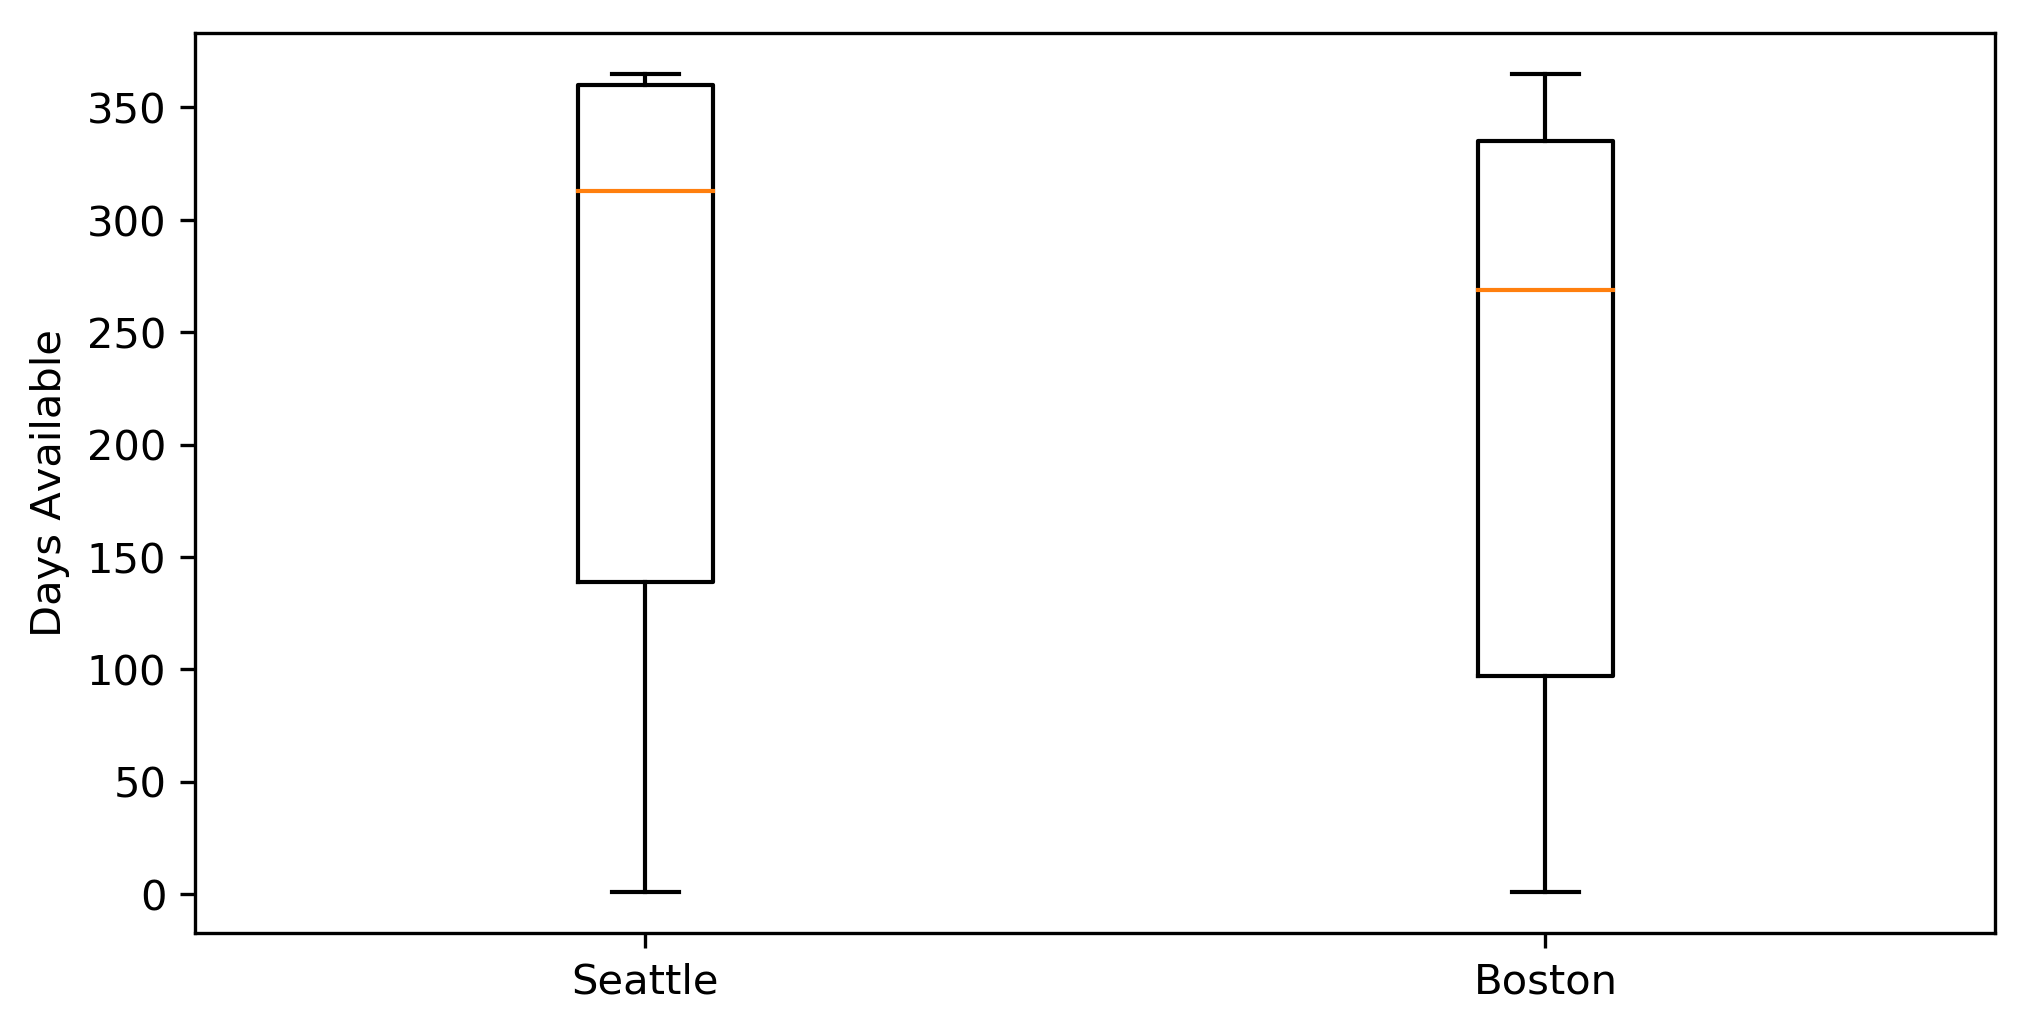

In [57]:
#create a box plot
fig = plt.figure(figsize=(6,3),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.boxplot([seattle_available.available.tolist(), boston_available.available.tolist()])
ax.set_xticklabels(['Seattle', 'Boston'])
ax.legend()
ax.set_ylabel('Days Available');
#there are bunch of outliers that skew the data

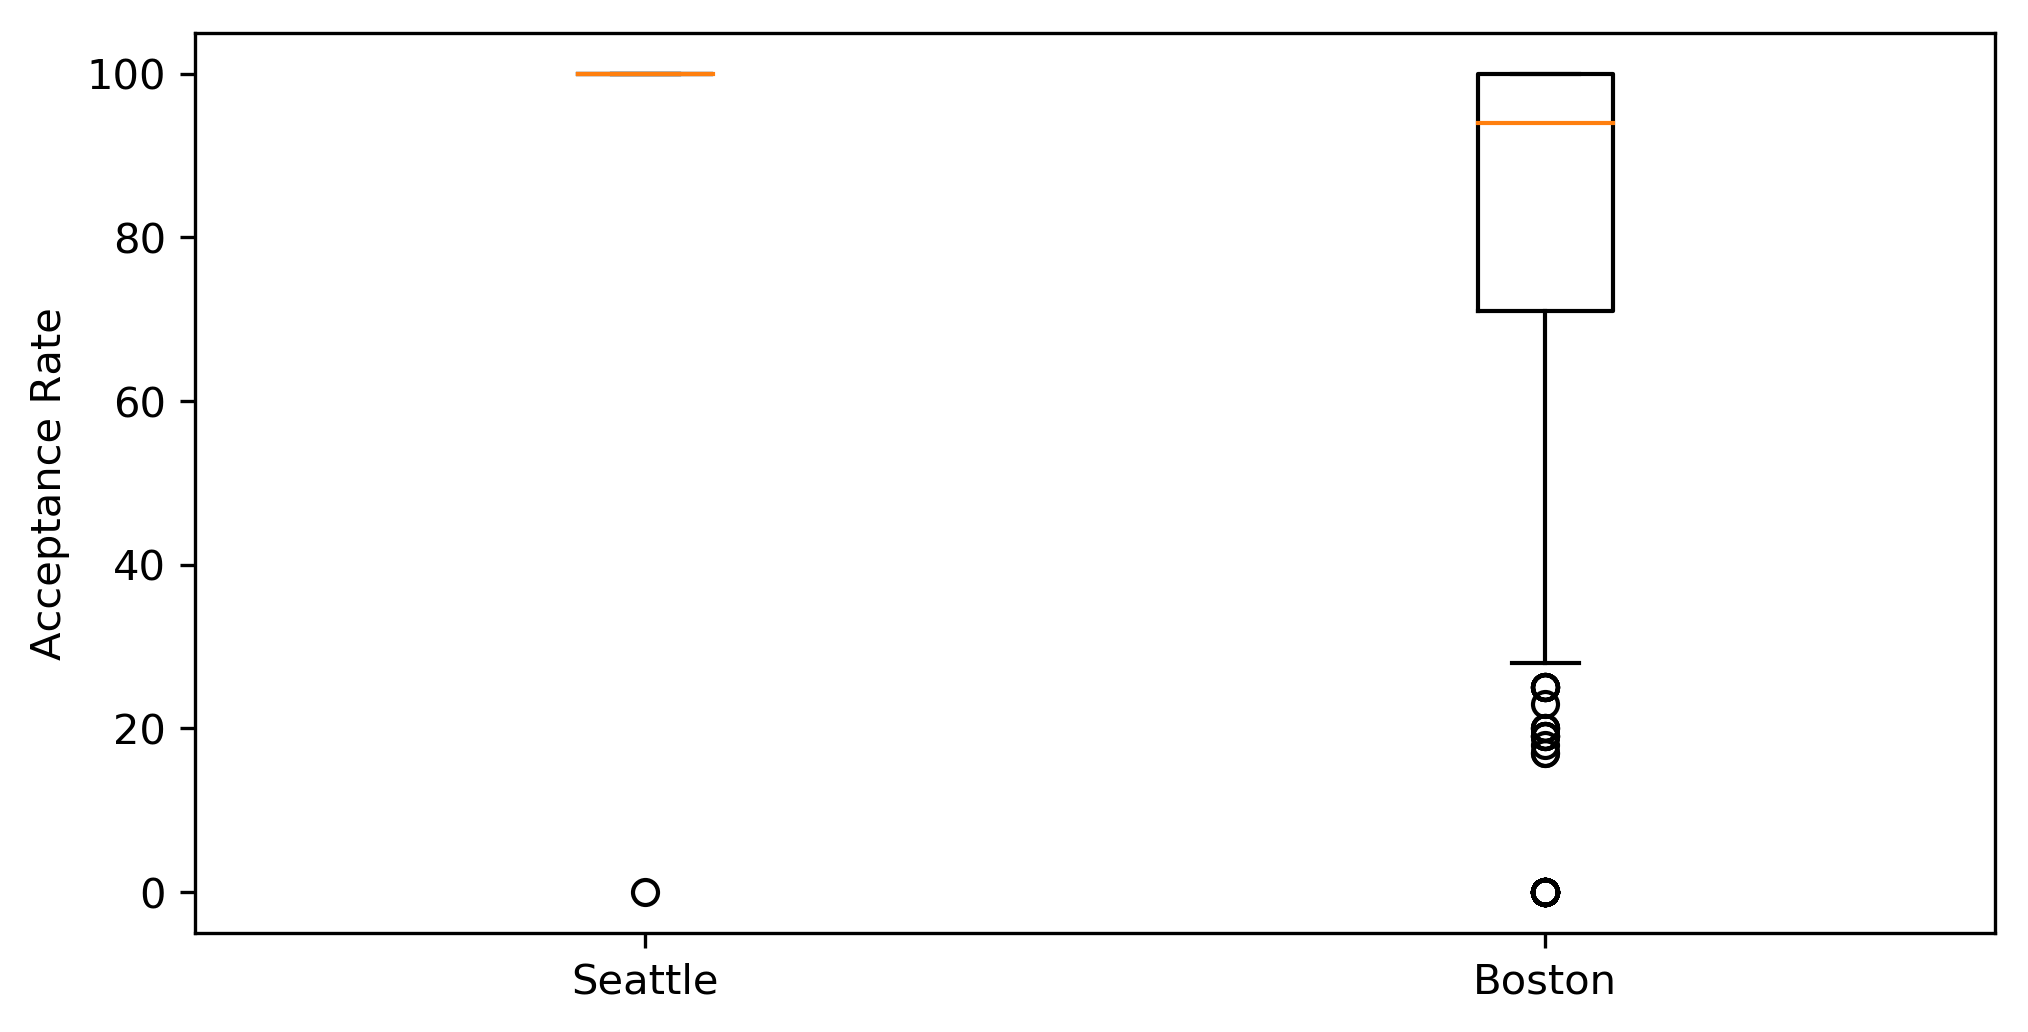

In [58]:
#look at the acceptance rate to find any trends

seattle_listings['acceptance'] = seattle_listings.host_acceptance_rate.str.replace('%','').astype('float')
boston_listings['acceptance'] = boston_listings.host_acceptance_rate.str.replace('%','').astype('float')
#create a box plot
fig = plt.figure(figsize=(6,3),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.boxplot([seattle_listings.acceptance.dropna().tolist(), boston_listings.acceptance.dropna().tolist()])
ax.set_xticklabels(['Seattle', 'Boston'])
ax.legend()
ax.set_ylabel('Acceptance Rate');

In [59]:
#bedromm  counts
#check if any of the values are null and dtypes
seattle_listings[['bedrooms', 'beds','price']].info()
seattle_listings['price'] = seattle_listings['price'].astype('str').str.replace("$","").str.replace(",","").astype('float')
seattle_listings.loc[seattle_listings.beds.isnull(), 'beds'] = -1
seattle_listings.loc[seattle_listings.bedrooms.isnull(), 'bedrooms'] = -1

seattle_listings['bedrms'] = seattle_listings.bedrooms.astype('str')
seattle_listings.loc[seattle_listings['bedrooms']>=5 ,'bedrms'] = '5+'
seattle_bedroom_stats = seattle_listings.groupby('bedrms').agg({'beds':'count', 'price':'mean'}).reset_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 3 columns):
bedrooms    3812 non-null float64
beds        3817 non-null float64
price       3818 non-null object
dtypes: float64(2), object(1)
memory usage: 89.6+ KB


In [60]:
#check if any of the values are null and dtypes
boston_listings[['bedrooms', 'beds','price']].info()
boston_listings['price'] = boston_listings['price'].astype('str').str.replace("$","").str.replace(",","").astype('float')
boston_listings.loc[boston_listings.beds.isnull(), 'beds'] = -1
boston_listings.loc[boston_listings.bedrooms.isnull(), 'bedrooms'] = -1

boston_listings['bedrms'] = boston_listings.bedrooms.astype('str')
boston_listings.loc[boston_listings['bedrooms']>=5 ,'bedrms'] = '5+'
boston_bedroom_stats = boston_listings.groupby('bedrms').agg({'beds':'count', 'price':'mean'}).reset_index()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 3 columns):
bedrooms    3575 non-null float64
beds        3576 non-null float64
price       3585 non-null object
dtypes: float64(2), object(1)
memory usage: 84.1+ KB


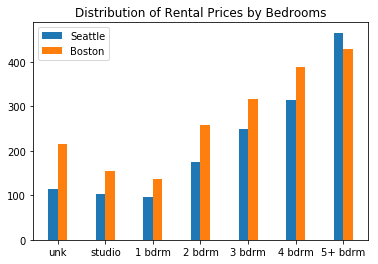

In [61]:
#create a bar chart with bed counts
#looks like seattle has slightly more appartments in all categories but 2 bdrm

labels =['unk', 'studio', '1 bdrm', '2 bdrm', '3 bdrm', '4 bdrm', '5+ bdrm']

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, seattle_bedroom_stats.price.tolist(), width, label='Seattle')
rects2 = ax.bar(x + width/2, boston_bedroom_stats.price.tolist(), width, label='Boston')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Distribution of Rental Prices by Bedrooms')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend();

In [62]:
#check if there is a different distribution be the number of accommodates

#check if any of the values are null and dtypes
boston_listings[['accommodates','price']].info()
boston_listings['price'] = boston_listings['price'].astype('str').str.replace("$","").str.replace(",","").astype('float')
boston_listings['ppl'] = boston_listings.accommodates.astype('str')
boston_listings.loc[boston_listings['accommodates']>=10 ,'ppl'] = '10+'
boston_acc_stats = boston_listings.groupby('ppl').agg({'price':'mean','accommodates': 'count'}).reset_index().sort_values(['ppl'])
#check if any of the values are null and dtypes
seattle_listings[['accommodates','price']].info()
seattle_listings['price'] = seattle_listings['price'].astype('str').str.replace("$","").str.replace(",","").astype('float')
seattle_listings['ppl'] = seattle_listings.accommodates.astype('str')
seattle_listings.loc[seattle_listings['accommodates']>=10 ,'ppl'] = '10+'
seattle_acc_stats = seattle_listings.groupby('ppl').agg({'price':'mean', 'accommodates':'count'}).reset_index().sort_values(['ppl'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 2 columns):
accommodates    3585 non-null int64
price           3585 non-null float64
dtypes: float64(1), int64(1)
memory usage: 56.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 2 columns):
accommodates    3818 non-null int64
price           3818 non-null float64
dtypes: float64(1), int64(1)
memory usage: 59.7 KB


In [63]:
s_price_per_person = seattle_listings.dropna(subset =['price']).groupby('accommodates').price.median().reset_index()
b_price_per_person = boston_listings.dropna(subset =['price']).groupby('accommodates').price.median().reset_index()
s_price_per_person['price_pp'] = s_price_per_person.price/s_price_per_person.accommodates
b_price_per_person['price_pp'] = b_price_per_person.price/s_price_per_person.accommodates
#add rows to boston
add_rows = list(set(s_price_per_person.accommodates) - set(b_price_per_person.accommodates))
for i in add_rows:
    b_price_per_person = b_price_per_person.append({'accommodates': i, 'price_pp':0}, ignore_index=True)
    


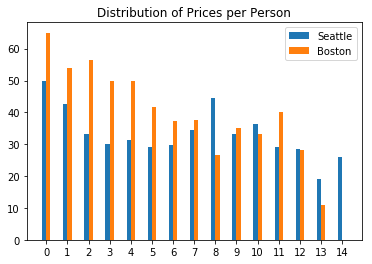

In [64]:
#create a bar chart with accommodate distribution
#looks like seattle has slightly more appartments in all categories but 2 bdrm

labels =b_price_per_person.accommodates.unique().tolist()


x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, s_price_per_person.price_pp.tolist(), width, label='Seattle')
rects2 = ax.bar(x + width/2, b_price_per_person.price_pp.tolist(), width, label='Boston')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Distribution of Prices per Person')
ax.set_xticks(x)
#ax.set_xticklabels(labels)
ax.legend();

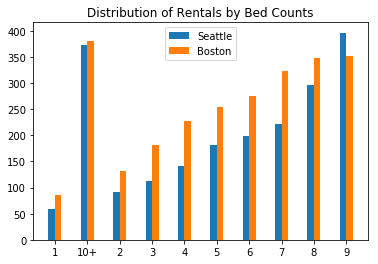

In [65]:
#create a bar chart with accommodate distribution
#looks like seattle has slightly more appartments in all categories but 2 bdrm

labels =seattle_acc_stats.ppl.unique().tolist()


x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, seattle_acc_stats.price.tolist(), width, label='Seattle')
rects2 = ax.bar(x + width/2, boston_acc_stats[boston_acc_stats.ppl!='-1'].price.tolist(), width, label='Boston')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Distribution of Rentals by Bed Counts')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend();

In [66]:
#get the average pricing by month; day of the year; day of the week in Seattle
seattle_calendar['month'] =  seattle_calendar.date.dt.month
seattle_calendar['week_day'] =  seattle_calendar.date.dt.dayofweek
seattle_calendar['day_of_the_year'] =  seattle_calendar.date.dt.dayofyear

seattle_price_stats = seattle_calendar
seattle_price_stats['monthly_avg'] = seattle_price_stats.groupby('month').price.transform('mean')
seattle_price_stats['dayofyear_avg'] = seattle_price_stats.groupby('day_of_the_year').price.transform('mean')
seattle_price_stats['weekday_avg'] = seattle_price_stats.groupby('week_day').price.transform('mean')

seattle_price_stats= seattle_price_stats.drop(['listing_id', 'date', 'price','available'], axis = 1).groupby(['month', 'day_of_the_year','week_day' ]).max().reset_index()

In [67]:
#get the average pricing by month; day of the year; day of the week in Boston
boston_calendar['month'] =  boston_calendar.date.dt.month
boston_calendar['week_day'] =  boston_calendar.date.dt.dayofweek
boston_calendar['day_of_the_year'] =  boston_calendar.date.dt.dayofyear
boston_price_stats = boston_calendar
boston_price_stats['monthly_avg'] = boston_price_stats.groupby('month').price.transform('mean')
boston_price_stats['dayofyear_avg'] = boston_price_stats.groupby('day_of_the_year').price.transform('mean')
boston_price_stats['weekday_avg'] = boston_price_stats.groupby('week_day').price.transform('mean')

boston_price_stats= boston_price_stats.drop(['listing_id', 'date', 'price','available'], axis = 1).groupby(['month', 'day_of_the_year','week_day' ]).max().reset_index()

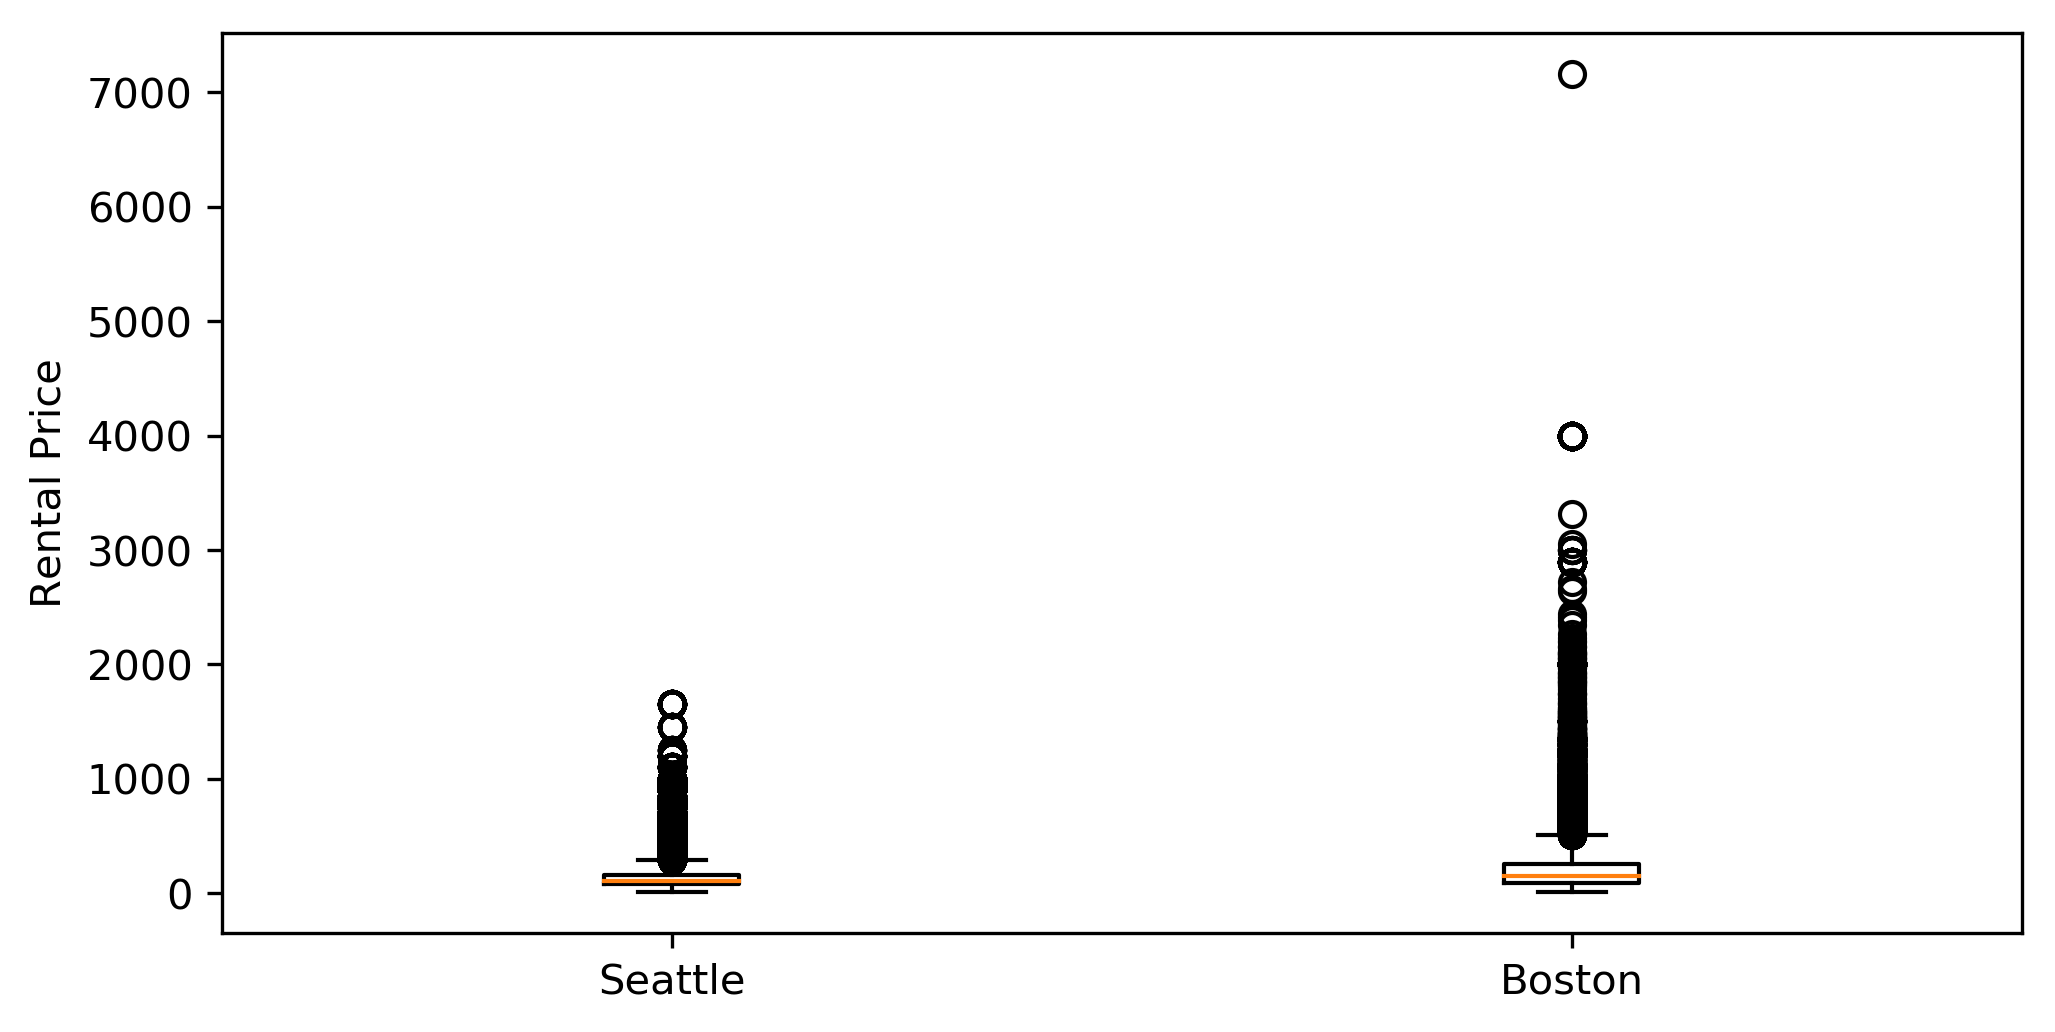

In [68]:
#box plot of price ranges
#looks like Boston has major outliers @ $7000
fig = plt.figure(figsize=(6,3),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.boxplot([seattle_calendar['price'].dropna(), boston_calendar['price'].dropna()])
ax.set_xticklabels(['Seattle', 'Boston'])
ax.legend()
ax.set_ylabel('Rental Price');

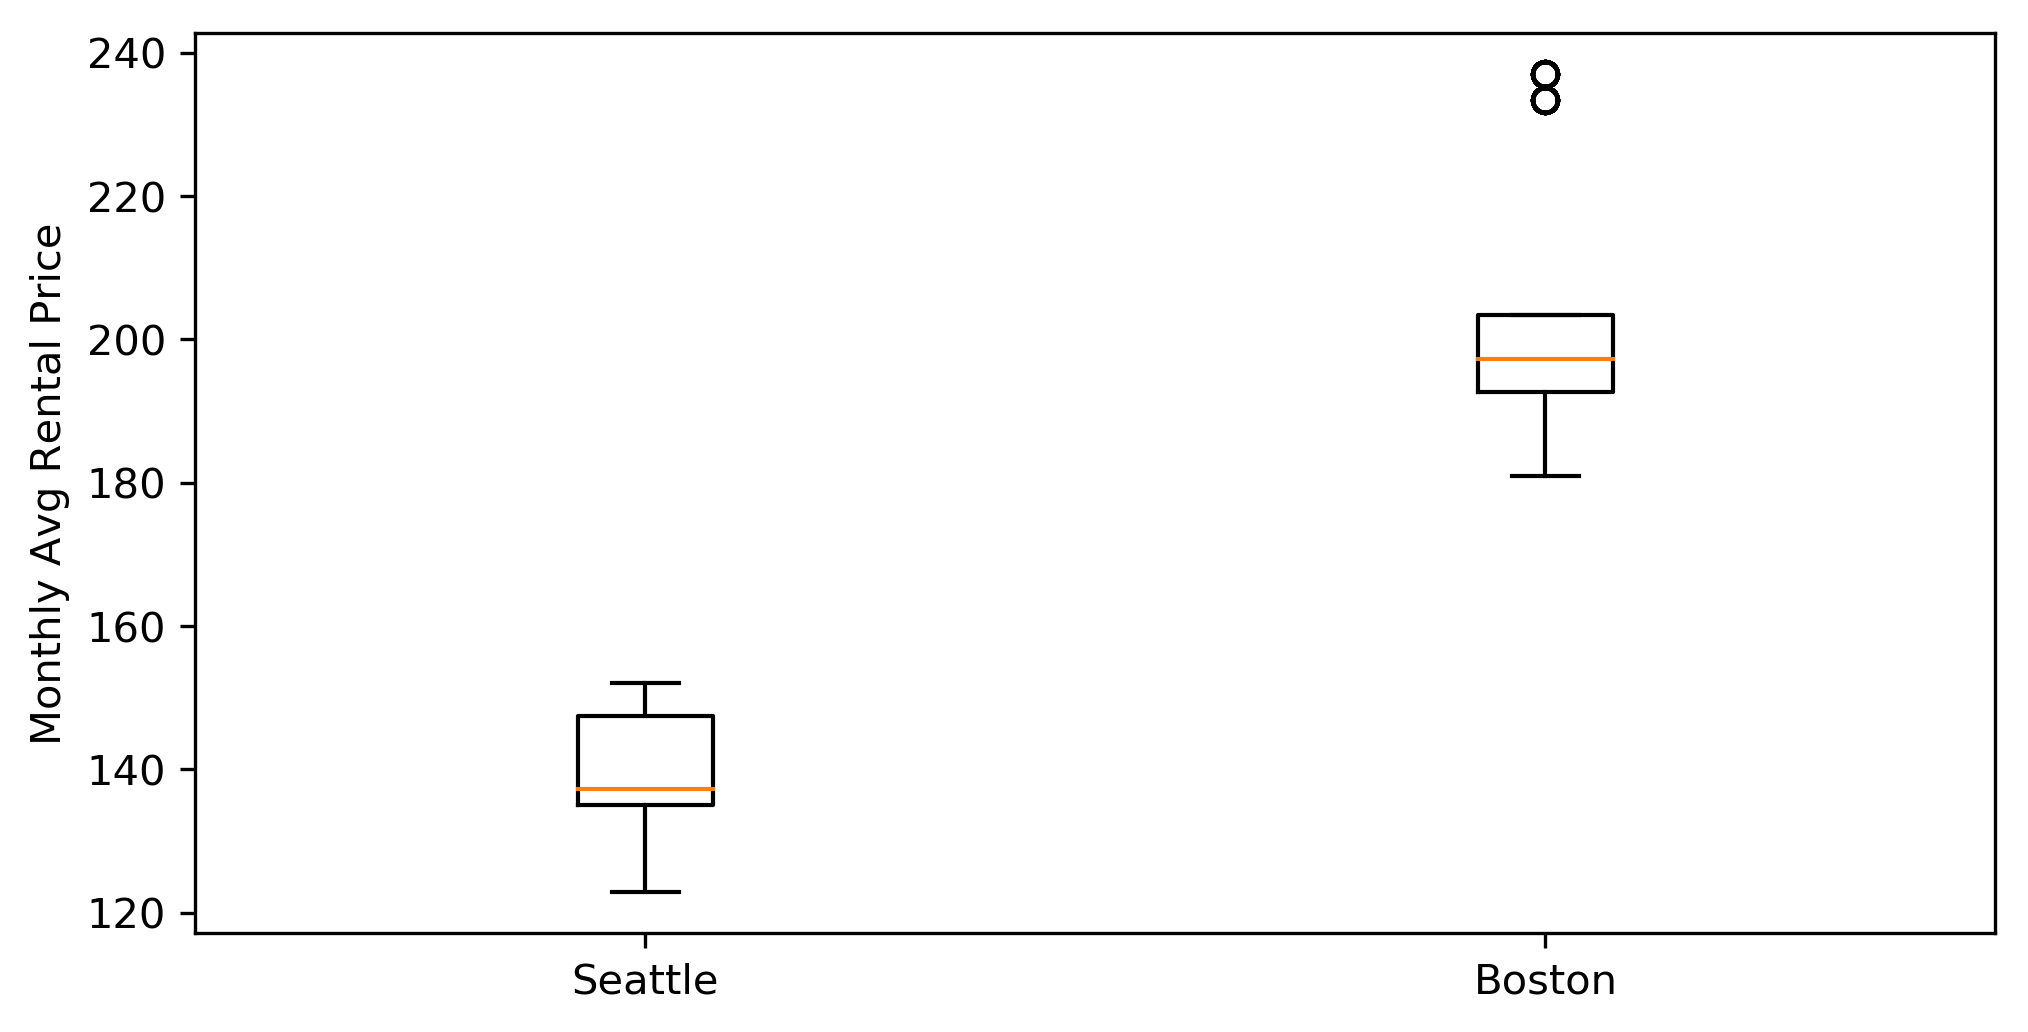

In [69]:
#lets take a look at the daily averages
#boston data still has way more outliers and they are all in the luxury price point
fig = plt.figure(figsize=(6,3),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.boxplot([seattle_price_stats['monthly_avg'], boston_price_stats['monthly_avg']])
ax.set_xticklabels(['Seattle', 'Boston'])
ax.legend()
ax.set_ylabel('Monthly Avg Rental Price');

### Q2 Seasonality

#### Create a plot demonstrating price distribution for every day of the year
Boston prices show more variation are significantly higher than the Seattle rentals.
Spike in April (100th day) signifies Boston Marathon and the other one in October (250-300) shows that Boston attracts tourist during the foliage, Halloween, Octoberfest.

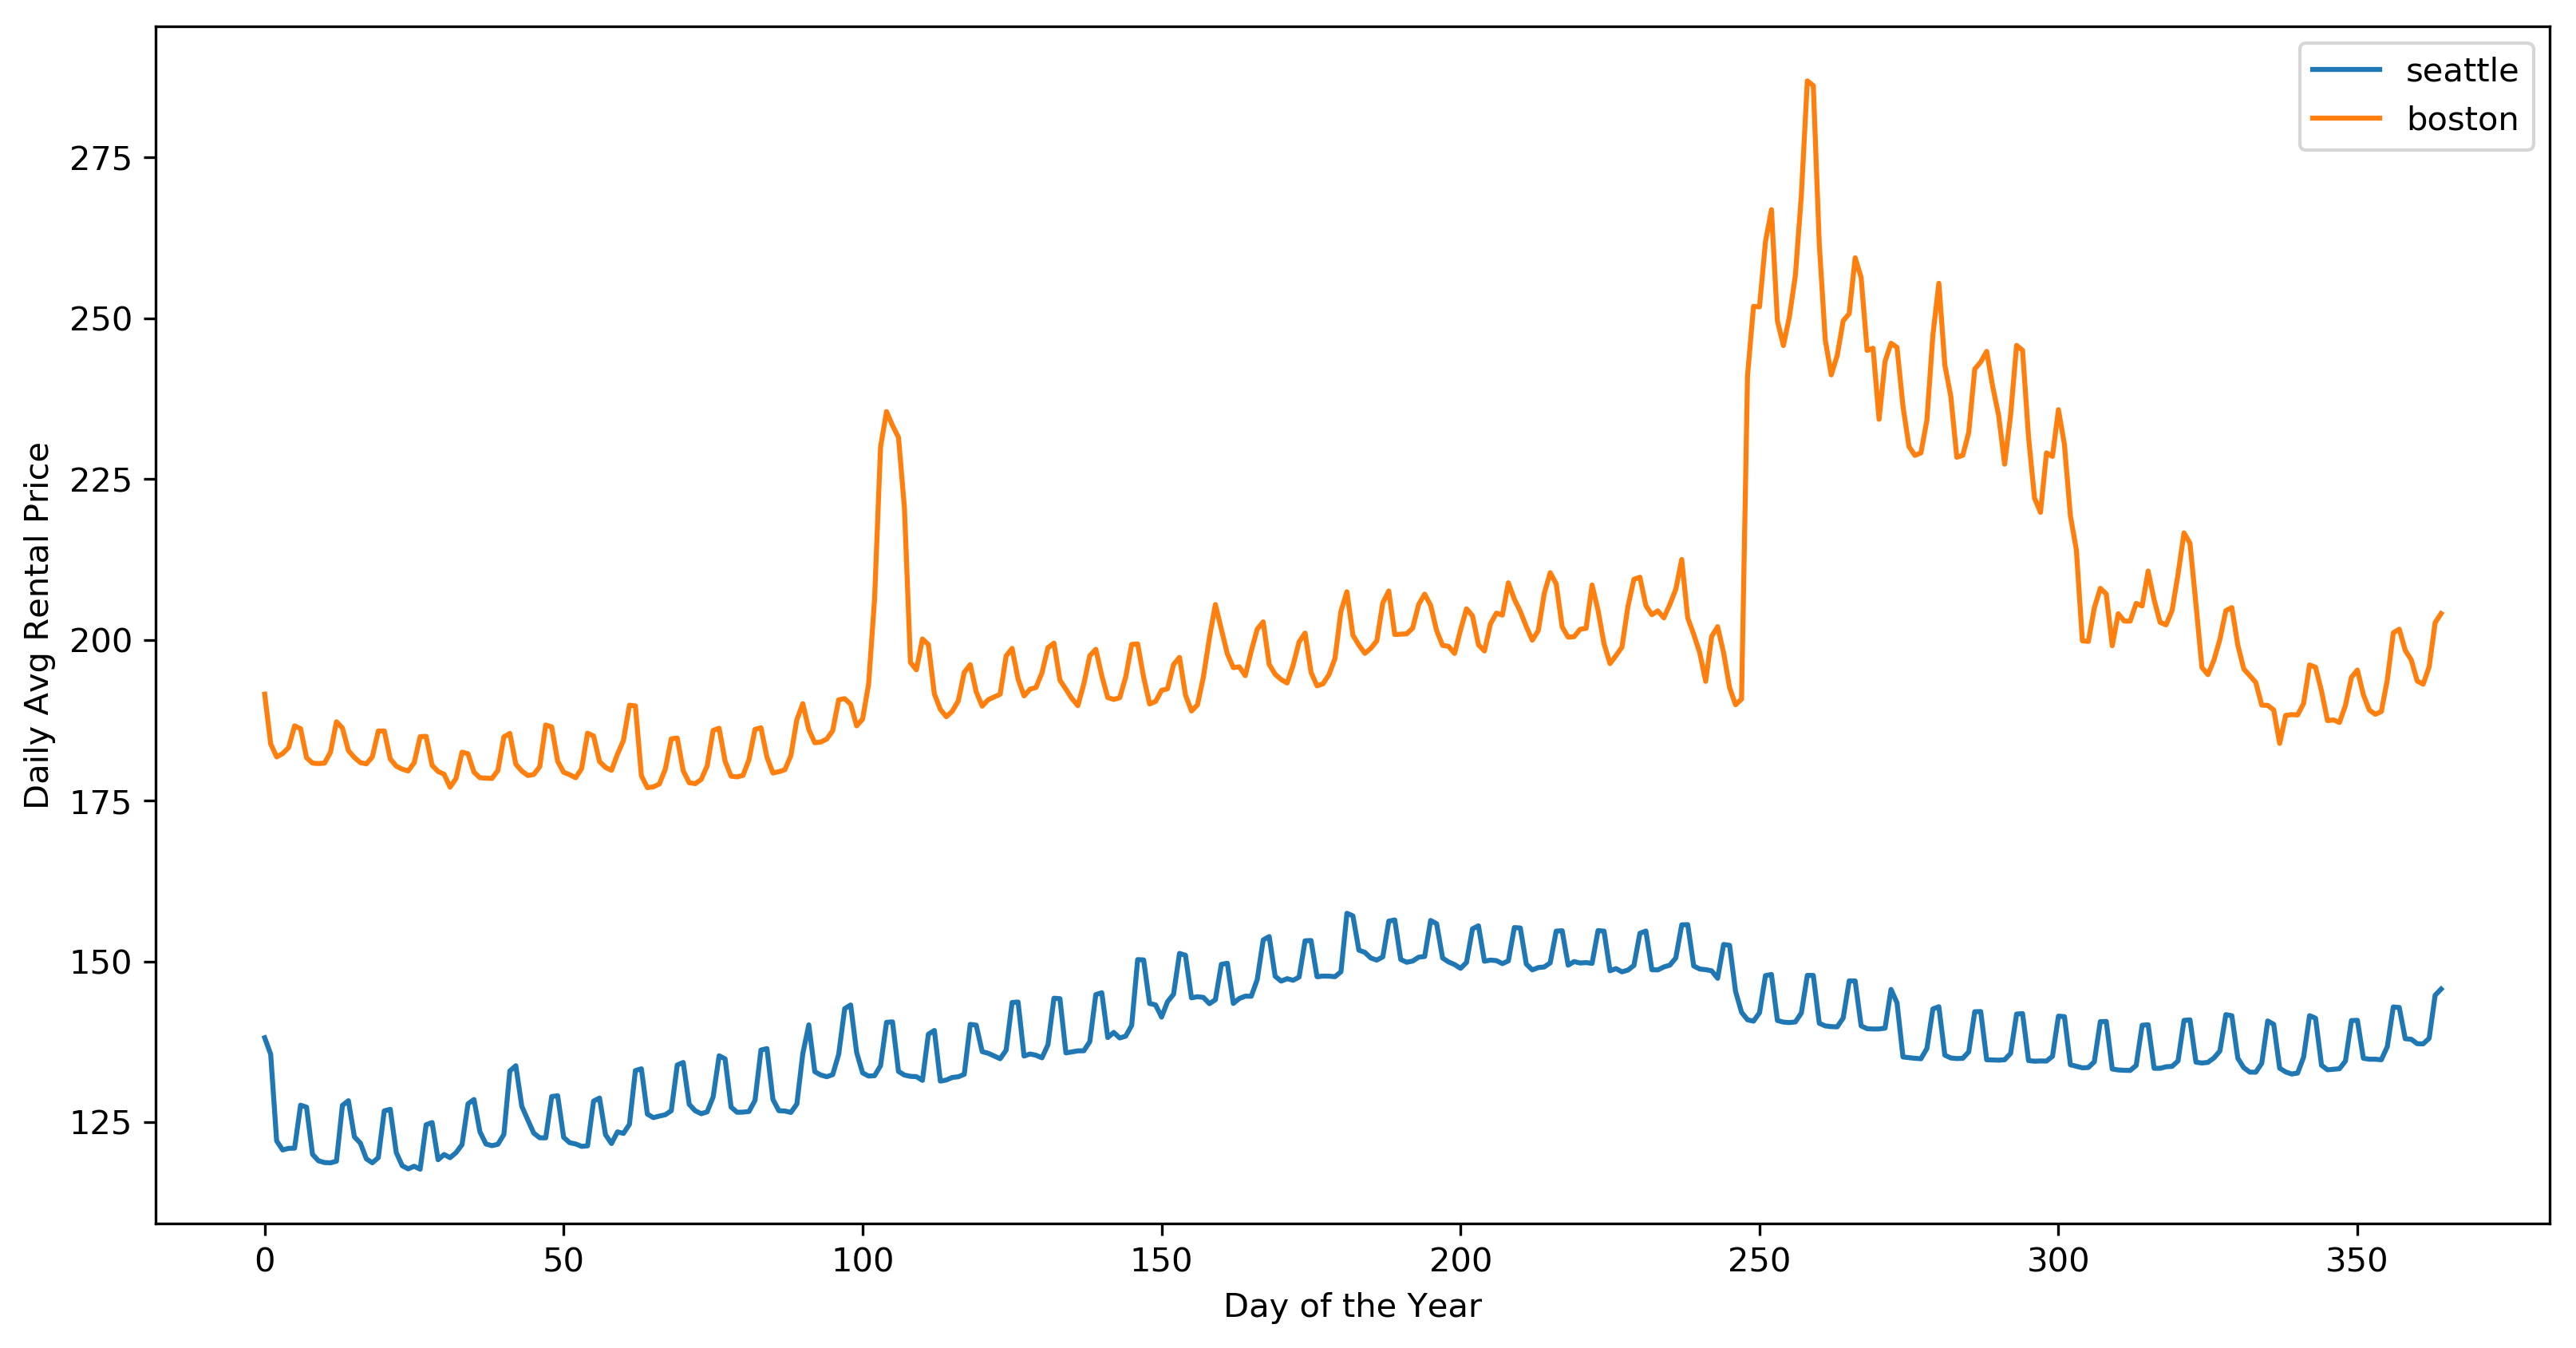

In [70]:
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.plot(seattle_price_stats['dayofyear_avg'], label='seattle')
ax.plot(boston_price_stats['dayofyear_avg'], label='boston')
ax.legend()
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Daily Avg Rental Price');

#### Create a plot to compare the pricing by weekday
Clearly, Boston market is more expencive, but both cities show clear trend for the weekend getaway.

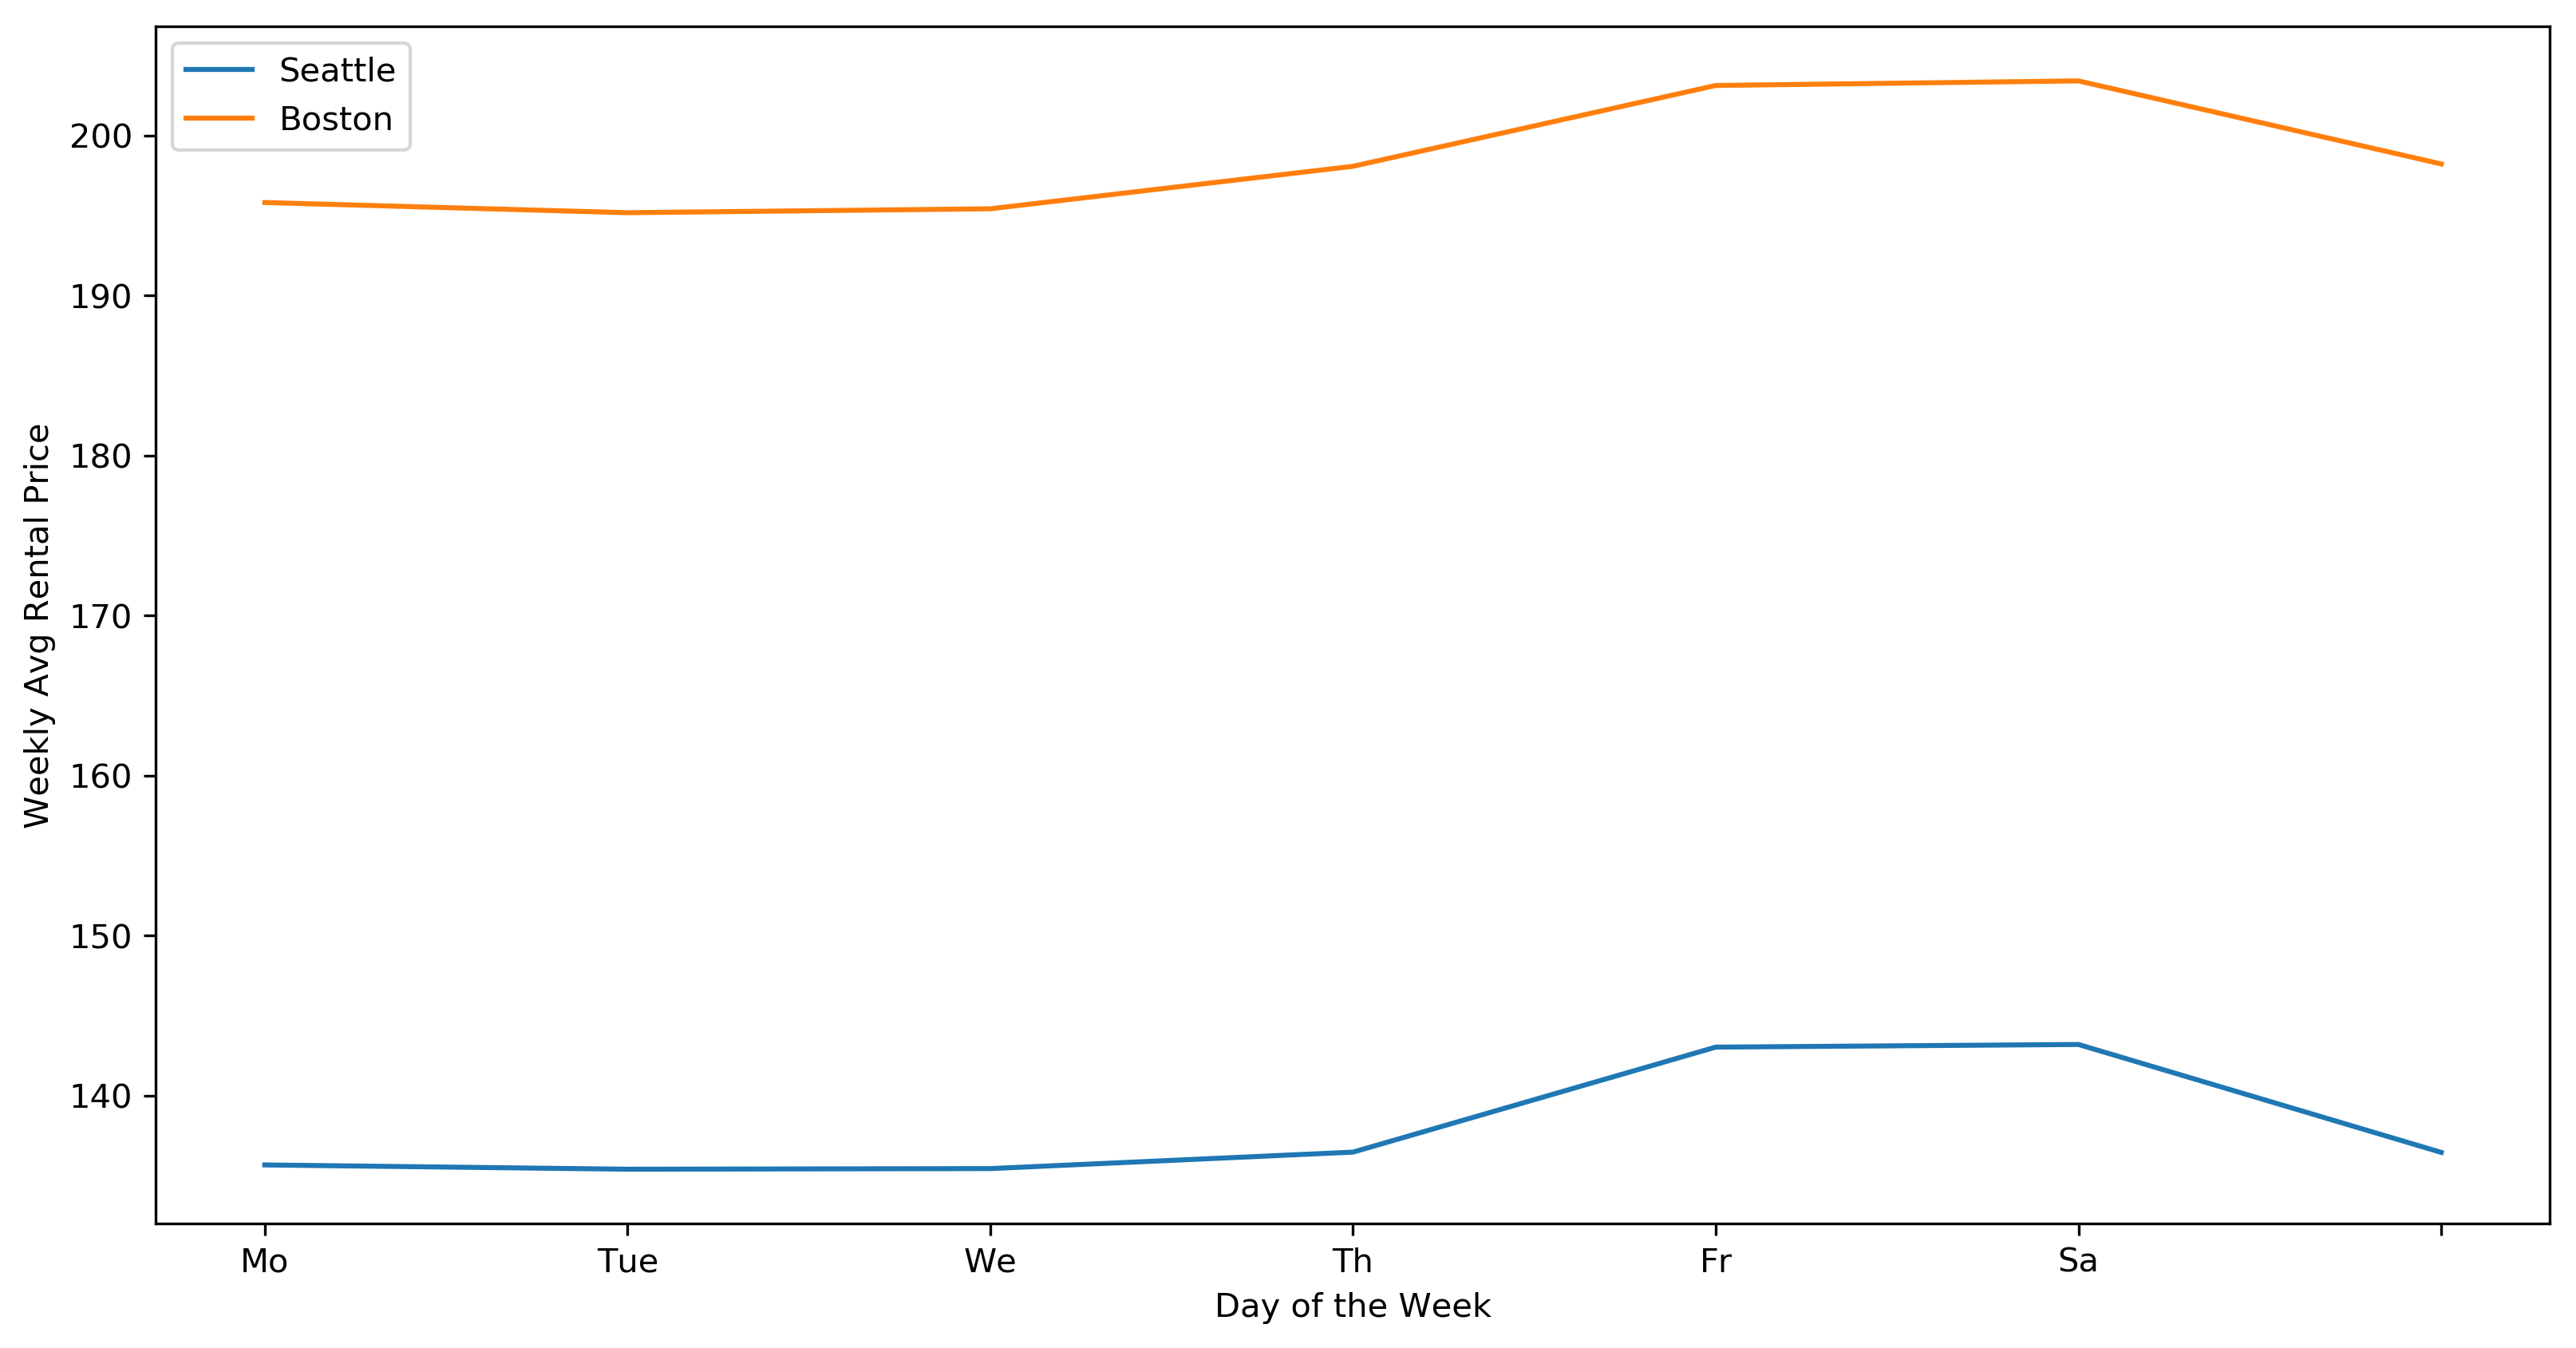

In [71]:
labels = ['Su','Mo', 'Tue', 'We', 'Th', 'Fr', 'Sa']
seattle_weekday = seattle_price_stats.groupby('week_day').weekday_avg.max()
boston_weekday = boston_price_stats.groupby('week_day').weekday_avg.max()

x = np.arange(len(labels))  # the label locations
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_axes([0,0,1,1])
rects1 = ax.plot(x, seattle_weekday,  label='Seattle')
rects2 = ax.plot(x, boston_weekday,  label='Boston')
ax.set_xticklabels(labels)
ax.legend()
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Weekly Avg Rental Price');


#### Create a plot to show any monthly trends and differences
Again, you can see the pricing variation and seasonality for Boston with the peaks around April and October.
However, now it is more clear that Seattle has it's renting peak in the summer months of July and August.

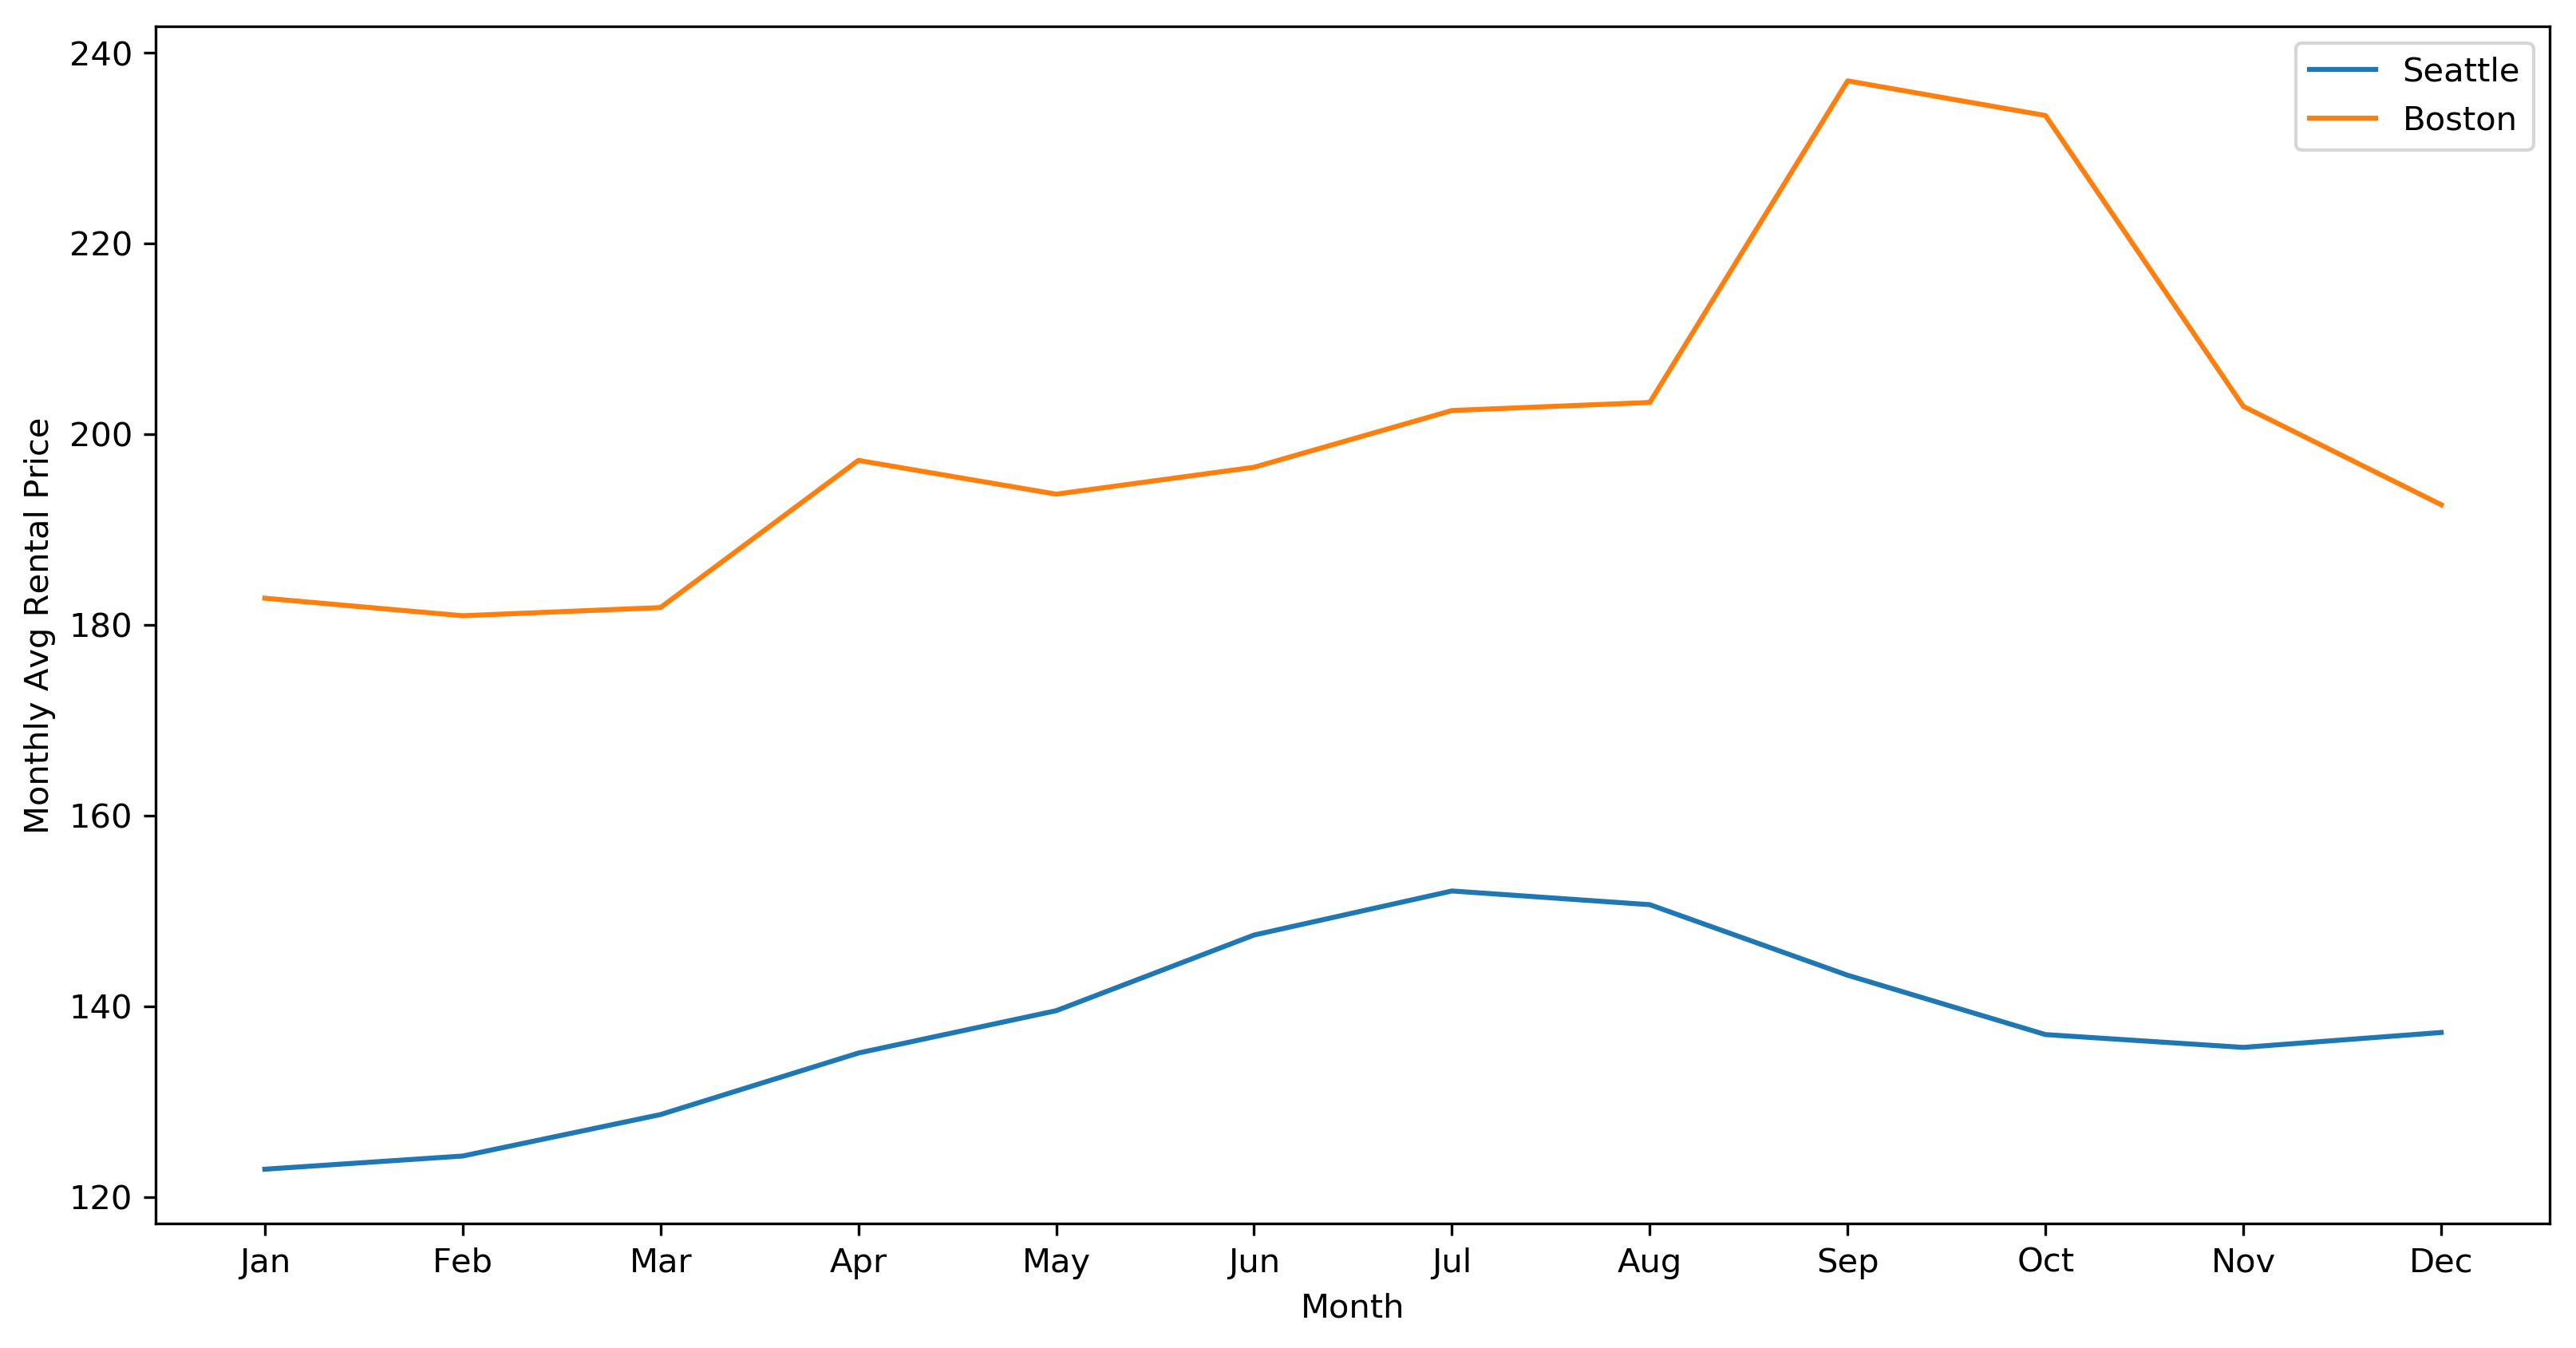

In [72]:
labels =[0,1,2,3,4,5,6,7,8,9,10,11] #seattle_price_stats.month.unique().tolist()
seattle_monthly = seattle_price_stats.groupby('month').monthly_avg.max()
boston_monthly = boston_price_stats.groupby('month').monthly_avg.max()

x = np.arange(len(labels))  # the label locations
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_axes([0,0,1,1])
rects1 = ax.plot(x, seattle_monthly,  label='Seattle')
rects2 = ax.plot(x, boston_monthly,  label='Boston')
ax.set_xticks(labels)
ax.set_xticklabels([ 'Jan',  'Feb',  'Mar', 'Apr',  'May',  'Jun',  'Jul',  'Aug',  'Sep', 'Oct', 'Nov', "Dec"])
ax.legend()
ax.set_xlabel('Month')
ax.set_ylabel('Monthly Avg Rental Price');

#### Q3 Linear model

In [73]:
#lets look at the categorical & num columns
#drop the cols from boston not in seattle
b_cols = boston_listings.columns
s_cols = seattle_listings.columns
boston_listings = boston_listings.drop(list(set(b_cols) - set(s_cols)), axis = 1)

In [142]:
#combine the two sets for predictive modeling
combo_df = pd.concat([seattle_listings,boston_listings])

#check what percentage of data is missing
c_null = combo_df.isnull().sum()/combo_df.shape[0]
print(c_null[c_null>0])

#remove the columns where more than 40% is missing
c_null = list(c_null[c_null>0.4].index.values)
c_null.remove('security_deposit')
combo_df = combo_df.drop(c_null, axis = 1)

#check if there are any rows that have many nulls
r_null = combo_df.isnull().sum(axis = 1)/combo_df.shape[0]
r_null.max() #0.004 - no need todo anything

summary                         0.043226
space                           0.219641
neighborhood_overview           0.330542
notes                           0.483723
transit                         0.300419
thumbnail_url                   0.124139
medium_url                      0.124139
xl_picture_url                  0.124139
host_name                       0.000270
host_since                      0.000270
host_location                   0.002567
host_about                      0.292854
host_response_time              0.134270
host_response_rate              0.134270
host_acceptance_rate            0.168040
host_is_superhost               0.000270
host_thumbnail_url              0.000270
host_picture_url                0.000270
host_neighbourhood              0.086316
host_listings_count             0.000270
host_total_listings_count       0.000270
host_has_profile_pic            0.000270
host_identity_verified          0.000270
neighbourhood                   0.129542
neighbourhood_gr

0.0041874915574766983

In [106]:
cat_s = combo_df.select_dtypes(include=['object'])
#number of unique values per column
c_drop = []
c_money = []
for col in cat_s.columns:
    print(col, cat_s[col].nunique(),np.sum(cat_s[col].isnull())/cat_s.shape[0])
    if cat_s[col].nunique()==1: #there are quite a few cols with only one value. Drop them
        c_drop.append(col)
    if cat_s[col].any()[:1] =='$':     # if the column contains $ keep it
        c_money.append(col)
    if (cat_s[col].nunique()>20) & (col not in c_money) &(col not in ['zipcode', 'id']): #there are quite a few cols with too many variations.Do not use them either
        c_drop.append(col)  #except zipcode       

#also drop these columns: most are about location - we keep the zip and ppl + bedrms is the one I've created for charts earlier
c_drop.extend(['last_scraped','calendar_last_scraped','scrape_id','latitude','longitude','smart_location', 'city','state','ppl','bedrms'])

cat_cols = list(set(cat_s.columns) - set(c_drop)-set(c_money))

last_scraped 2 0.0
host_response_time 4 0.134269890585
host_is_superhost 2 0.000270160745644
host_has_profile_pic 2 0.000270160745644
host_identity_verified 2 0.000270160745644
zipcode 70 0.0
market 5 0.00189112521951
is_location_exact 2 0.0
property_type 19 0.000540321491287
room_type 3 0.0
bed_type 5 0.0
calendar_last_scraped 2 0.0
instant_bookable 2 0.0
cancellation_policy 4 0.0
require_guest_profile_picture 2 0.0
require_guest_phone_verification 2 0.0


['host_identity_verified',
 'is_location_exact',
 'zipcode',
 'market',
 'host_response_time',
 'instant_bookable',
 'require_guest_phone_verification',
 'cancellation_policy',
 'require_guest_profile_picture',
 'host_is_superhost',
 'bed_type',
 'host_has_profile_pic',
 'room_type',
 'property_type']

In [76]:
#transform few features that are not showing correctly
combo_df.zipcode = combo_df.zipcode.str.extract(r'(\d+)(?<![^0-9])').fillna('98')

#convert money columns to int
#replace nulls with 0
combo_df[c_money] = combo_df[c_money].fillna('$0')
for col in c_money:
    combo_df[col] = combo_df[col].str[1:].str.replace(',','').astype('float')


In [77]:
#drop irrelevant columns
combo_df = combo_df.drop(c_drop, axis =1)

In [93]:
#subset the numeric fields
num_cols = combo_df.select_dtypes(include=['int64', 'float64']).columns

In [94]:
#fill the null values for numeric: replace with a catchy number that will be easy to separate from the real values
#if more time is available try other imputing strategies
combo_df[num_cols] = combo_df[num_cols].fillna(-1)

In [96]:
#correlate the price to the other vars
c_corr = combo_df[num_cols].corr()['price'][:].sort_values()
c_corr[abs(c_corr)>0.1]

reviews_per_month                -0.159025
acceptance                       -0.124048
number_of_reviews                -0.110149
calculated_host_listings_count    0.165068
host_total_listings_count         0.184795
host_listings_count               0.184795
security_deposit                  0.204671
guests_included                   0.250212
bathrooms                         0.326222
cleaning_fee                      0.392417
beds                              0.422381
bedrooms                          0.445980
accommodates                      0.479576
price                             1.000000
Name: price, dtype: float64

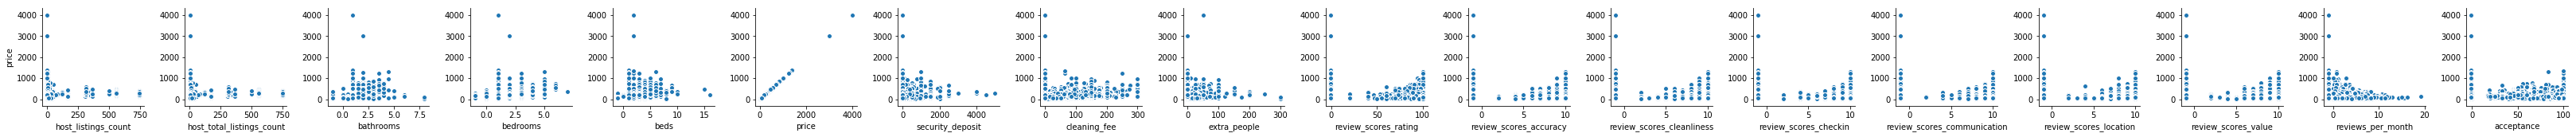

In [87]:
sns.pairplot(combo_df[num_cols], y_vars="price", x_vars=combo_df[num_cols].columns.values);

In [81]:
#write a function to replace columns that we kept with dummy vars
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [107]:
combo_df_dummy = create_dummy_df(combo_df,cat_cols, True)

In [109]:
corr_df = combo_df_dummy.corr()['price'][:].sort_values()
features = corr_df[abs(corr_df)>0.1].index.values
#use these as the features
corr_df[abs(corr_df)>0.1]

room_type_Private room                -0.371491
market_Seattle                        -0.185172
reviews_per_month                     -0.159025
acceptance                            -0.124048
room_type_Shared room                 -0.112422
number_of_reviews                     -0.110149
zipcode_02118                          0.101217
zipcode_02215                          0.110212
bed_type_Real Bed                      0.114653
zipcode_02210                          0.133146
cancellation_policy_strict             0.147097
zipcode_02116                          0.149729
cancellation_policy_super_strict_30    0.151142
calculated_host_listings_count         0.165068
host_total_listings_count              0.184795
host_listings_count                    0.184795
security_deposit                       0.204671
guests_included                        0.250212
bathrooms                              0.326222
cleaning_fee                           0.392417
beds                                   0

In [111]:
#create the X and y for the linear model
#Split into explanatory and response variables
#X = combo_df_dummy.drop(['price'], axis = 1)
#y = combo_df_dummy['price']

#try num_vars only
#X = combo_df.select_dtypes(include=['int', 'float']).drop(['price'], axis = 1)
#y = combo_df.price

#try selected features showing higher correlation with price
X = combo_df_dummy[features].drop(['price'], axis = 1)
y = combo_df_dummy['price']
#create train and test set
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test) 
print("The r-squared score for the model was {} on train values and {} on test values".format(r2_score(y_train, y_train_preds), r2_score(y_test, y_test_preds)))

compare_y = pd.DataFrame({'y_test': y_test, 'y_pred': y_test_preds})
compare_y['error_rate'] = round((1- compare_y.y_pred/compare_y.y_test)*100)
print('absolute  error: median, min and  max: ', abs(compare_y.error_rate.median()),compare_y.error_rate.min(),compare_y.error_rate.max() )
compare_y.head(10)

The r-squared score for the model was 0.37993670296902715 on train values and 0.500530645386025 on test values
absolute  error: median, min and  max:  7.0 -608.0 91.0


,y_pred,y_test,error_rate
548,353.025414,500.0,29.0
3197,310.369313,310.0,-0.0
549,157.989729,99.0,-60.0
1196,206.240029,199.0,-4.0
554,294.741289,325.0,9.0
2422,159.613576,123.0,-30.0
875,91.672836,99.0,7.0
3770,49.256111,65.0,24.0
2227,150.219395,99.0,-52.0
263,314.336789,335.0,6.0


In [118]:
cdf = pd.DataFrame(lm_model.coef_, X.columns, columns=['Coefficients'])
print(cdf)

                                     Coefficients
room_type_Private room                 -56.332206
market_Seattle                         -38.086332
reviews_per_month                       -3.583452
acceptance                              -0.249496
room_type_Shared room                  -63.656052
number_of_reviews                        0.034267
zipcode_02118                           46.839743
zipcode_02215                           74.320468
bed_type_Real Bed                       10.535781
zipcode_02210                          140.361780
cancellation_policy_strict               0.867174
zipcode_02116                           49.732287
cancellation_policy_super_strict_30    111.662275
calculated_host_listings_count          -0.114547
host_total_listings_count               -0.017122
host_listings_count                     -0.017122
security_deposit                         0.022812
guests_included                          2.141588
bathrooms                               24.139598


The linear model shows really poor performance.
Let's switch to an XGBoost model and see if that will show better performance

In [119]:
## convert the dataset into an optimized data structure called Dmatrix that XGBoost supports
data_dmatrix = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)

## parameter dictionary holder
params = []

## candidate parameters
max_depths =  [5]
gammas = [0]
learning_rates = [ 0.1]
subsamples = [ 1]
reg_lambdas = [1]
colsample_bytrees = [0.7]

## manually grid search cv
for max_depth in max_depths:
    for gamma in gammas:
        for learning_rate in learning_rates:
            for subsample in subsamples:
                for reg_lambda in reg_lambdas:
                    for colsample_bytree in colsample_bytrees:
                        ## define hyper parameters for xgbregressor
                        param = dict(max_depth=max_depth, 
                                           gamma=gamma, 
                                           learning_rate=learning_rate, 
                                           subsample = subsample, 
                                           reg_lambda=reg_lambda, 
                                           colsample_bytree=colsample_bytree)
                        ## retrieve cv results dataframe
                        cv_results = xgb.cv(dtrain=data_dmatrix, params=param, nfold=5,
                                            num_boost_round=50, early_stopping_rounds=20, 
                                            metrics="rmse", as_pandas=True, seed=(777*29)%10000)
                        cv_score = cv_results["test-rmse-mean"].iloc[-1]
                        ## append the score and parameters to params
                        params.append((cv_score, param))


## get best parameters that gives lowest validation rmse score
params = sorted(params, key=lambda x: x[0])
best_params = params[0][1]
best_valid_score = params[0][0]

## train the model with best parameters
xgb_reg = xgb.XGBRegressor(max_depth=best_params['max_depth'], gamma=best_params['gamma'], 
                           learning_rate=best_params['learning_rate'], subsample=best_params['subsample'], 
                           reg_lambda=best_params['reg_lambda'], colsample_bytree=best_params['colsample_bytree'], 
                           n_estimators = 100)
xgb_reg.fit(X_train, y_train)

## print out results
print("======= CV Result =======")
print("> best validation score: {:.4f}".format(best_valid_score))
print("> Best hyper parameters:")
print("  ", best_params)

======= CV Result =======
> best validation score: 105.3998
> Best hyper parameters:
   {'max_depth': 5, 'gamma': 0, 'learning_rate': 0.1, 'subsample': 1, 'reg_lambda': 1, 'colsample_bytree': 0.7}


In [90]:
## predict
y_pred = xgb_reg.predict(X_test)

## evaluate on test data
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("======= Result =======")
print("> test r-squared: {:.4f}".format(r2))
print("> test RMSE: {:.4f}".format(rmse))

compare_xgb = pd.DataFrame({'y_test': y_test, 'y_pred': y_test_preds})
compare_xgb['error_rate'] = abs(round((1- compare_xgb.y_pred/compare_xgb.y_test)*100))
compare_xgb.head(10)

======= Result =======
> test r-squared: 0.4394
> test RMSE: 84.1411


,y_pred,y_test,error_rate
548,337.472045,500.0,33.0
3197,362.479423,310.0,17.0
549,124.841995,99.0,26.0
1196,117.992931,199.0,41.0
554,275.292825,325.0,15.0
2422,89.757980,123.0,27.0
875,90.614528,99.0,8.0
3770,132.409214,65.0,104.0
2227,114.845621,99.0,16.0
263,335.802200,335.0,0.0


Top 10 important features:
 ['bedrooms', 'room_type_Private room', 'cancellation_policy_strict', 'market_Seattle', 'bathrooms', 'cleaning_fee', 'accommodates', 'guests_included', 'acceptance', 'beds']


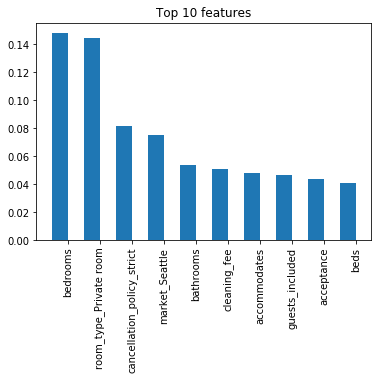

In [139]:
## visualize it
features = sorted(zip(xgb_reg.feature_importances_, X_train.columns), reverse=True)
attr = []
coef = []
number = 10

for feature in features:
    attr.append(feature[1]) 
    coef.append(feature[0])

fs = pd.DataFrame({'feature':attr, 'coef':coef})[:number]

labels =fs.feature.tolist()
x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fs.coef.tolist(), width)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Top {} features'.format(number))
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90)
ax.legend();


## print features
print("Top {} important features:\n {}".format(number, attr[:number]))